<a href="https://www.kaggle.com/code/ouzcanmaden/house-price-prediction?scriptVersionId=158040994" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.model_selection import cross_val_score
import logging
import optuna
from sklearn.ensemble import StackingRegressor
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


<h1 style="color:#FFFFFF;
           text-align:center;
           display:fill;
           border-radius:7px;
           background-color:#990000;
           font-size:250%;
           font-family:Arial, sans-serif;
           font-weight:bold;
           padding: 15px;
           letter-spacing:0.5px">
    House Price Prediction
</h1>
<div style="text-align:right; 
            margin-top: -20px; 
            font-family: Arial; 
            font-style: italic;">
    by Oguzcan Maden
</div>
<hr style="border: none;
           height: 6px; 
           border-radius:7px;
           background-color: #990000; 
           margin: 20px auto;">
           
 
<p style="font-size: 18px; text-align: justify;">In this Kaggle notebook for the House Price Prediction Advanced Regression Techniques competition, I implemented a stacked regressor approach. The methodology involves systematically exploring and preprocessing the dataset, including addressing missing values and handling categorical features. Feature engineering is employed to extract valuable insights, and a stacked regressor is chosen for its predictive power. The notebook also details the fine-tuning of hyperparameters and rigorous cross-validation to ensure the model's robustness and generalizability. Through transparent documentation, the notebook showcases the utilization of a stacked regressor as a key component in constructing an effective machine learning model for predicting house prices, contributing to the competition's advanced regression techniques.</p>



# **A. Data Loading and Exploratory Data Analysis**

In [2]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv").drop("Id",axis=1)
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv").drop("Id",axis=1)
data = pd.concat([train, test], ignore_index=True)
df = data.copy()

## **1. Overview of the Dataset**

In [3]:
def perform_EDA(dataframe):
    """
    Perform Exploratory Data Analysis (EDA) on the given dataframe.

    Parameters:
        dataframe (pandas.DataFrame): The dataframe to perform EDA on.

    Prints:
        - Dataset Sample: Displays a sample of the dataset.
        - Dataset Information: Provides information about the dataset.
        - Duplicated Values: Calculates and displays the sum of duplicated values in the dataset.
        - Unique Values: Displays the count of unique values in each column of the dataset.
        - Dataset Description: Provides descriptive statistics of the dataset.

    Returns:
        None
    """
    print("---- Dataset Sample ".ljust(50, '-'))
    print('')
    print(dataframe.sample(n=10))
    print('')
    print("---- Dataset Information ".ljust(50, '-'))
    print('')
    print(dataframe.info())
    print('')
    print("---- Duplicated Values ".ljust(50, '-'))
    print('')
    print('Sum of Duplicated Values:', dataframe.duplicated().sum())
    print('')
    print('')
    print("---- Unique Values ".ljust(50, '-'))
    print('')
    print(dataframe.nunique())
    print('')
    print("---- Dataset Description ".ljust(50, '-'))
    print('')
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print('')


perform_EDA(df)


---- Dataset Sample ------------------------------

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1401          60       RL         62.0     7415   Pave   NaN      IR1   
1361          20       RL        124.0    16158   Pave   NaN      IR1   
1284          50       RL         50.0     9638   Pave   NaN      Reg   
2598          20       RL         85.0    12633   Pave   NaN      IR1   
2143         190       RL         60.0    12900   Pave   NaN      Reg   
1264         120       RH         34.0     4060   Pave   NaN      Reg   
1895          50       RL         45.0     8212   Pave  Grvl      Reg   
1261          20       RL         80.0     9600   Pave   NaN      Reg   
701           20       RL         80.0     9600   Pave   NaN      Reg   
2215          50       RM         75.0     9000   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
1401         Lvl    AllPub    Inside  ...        0    NaN   NaN  

## **2. Numeric and Categorical Variables**

In [4]:
def find_col_dtypes(data, ord_th):
    num_cols = data.select_dtypes("number").columns.tolist()
    cat_cols = data.select_dtypes("object").columns.tolist()
    
    ordinals = [col for col in num_cols if data[col].nunique() < ord_th]
    
    return num_cols, ordinals, cat_cols

num_cols, ordinals, cat_cols = find_col_dtypes(test, 20)

print(f"Num Cols: {len(num_cols)}\n")
print(f"Cat Cols: {len(cat_cols)}\n")
print(f"Ordinal Cols: {len(ordinals)}")



Num Cols: 36

Cat Cols: 43

Ordinal Cols: 17


<p style="font-size: 18px; text-align: justify;">The dataset comprises a total of 36 numeric columns, capturing quantitative information, and 43 categorical columns, encapsulating qualitative attributes. Additionally, there are 17 ordinal columns denoting variables with ordered categories. This distribution highlights the diverse nature of the dataset, encompassing both numerical and categorical features, along with a subset exhibiting ordinal characteristics. A nuanced understanding of these column types is imperative for formulating a comprehensive exploratory data analysis and building effective predictive models in subsequent stages of the analysis.</p>


## **3. Analysis of Categorical Variables**

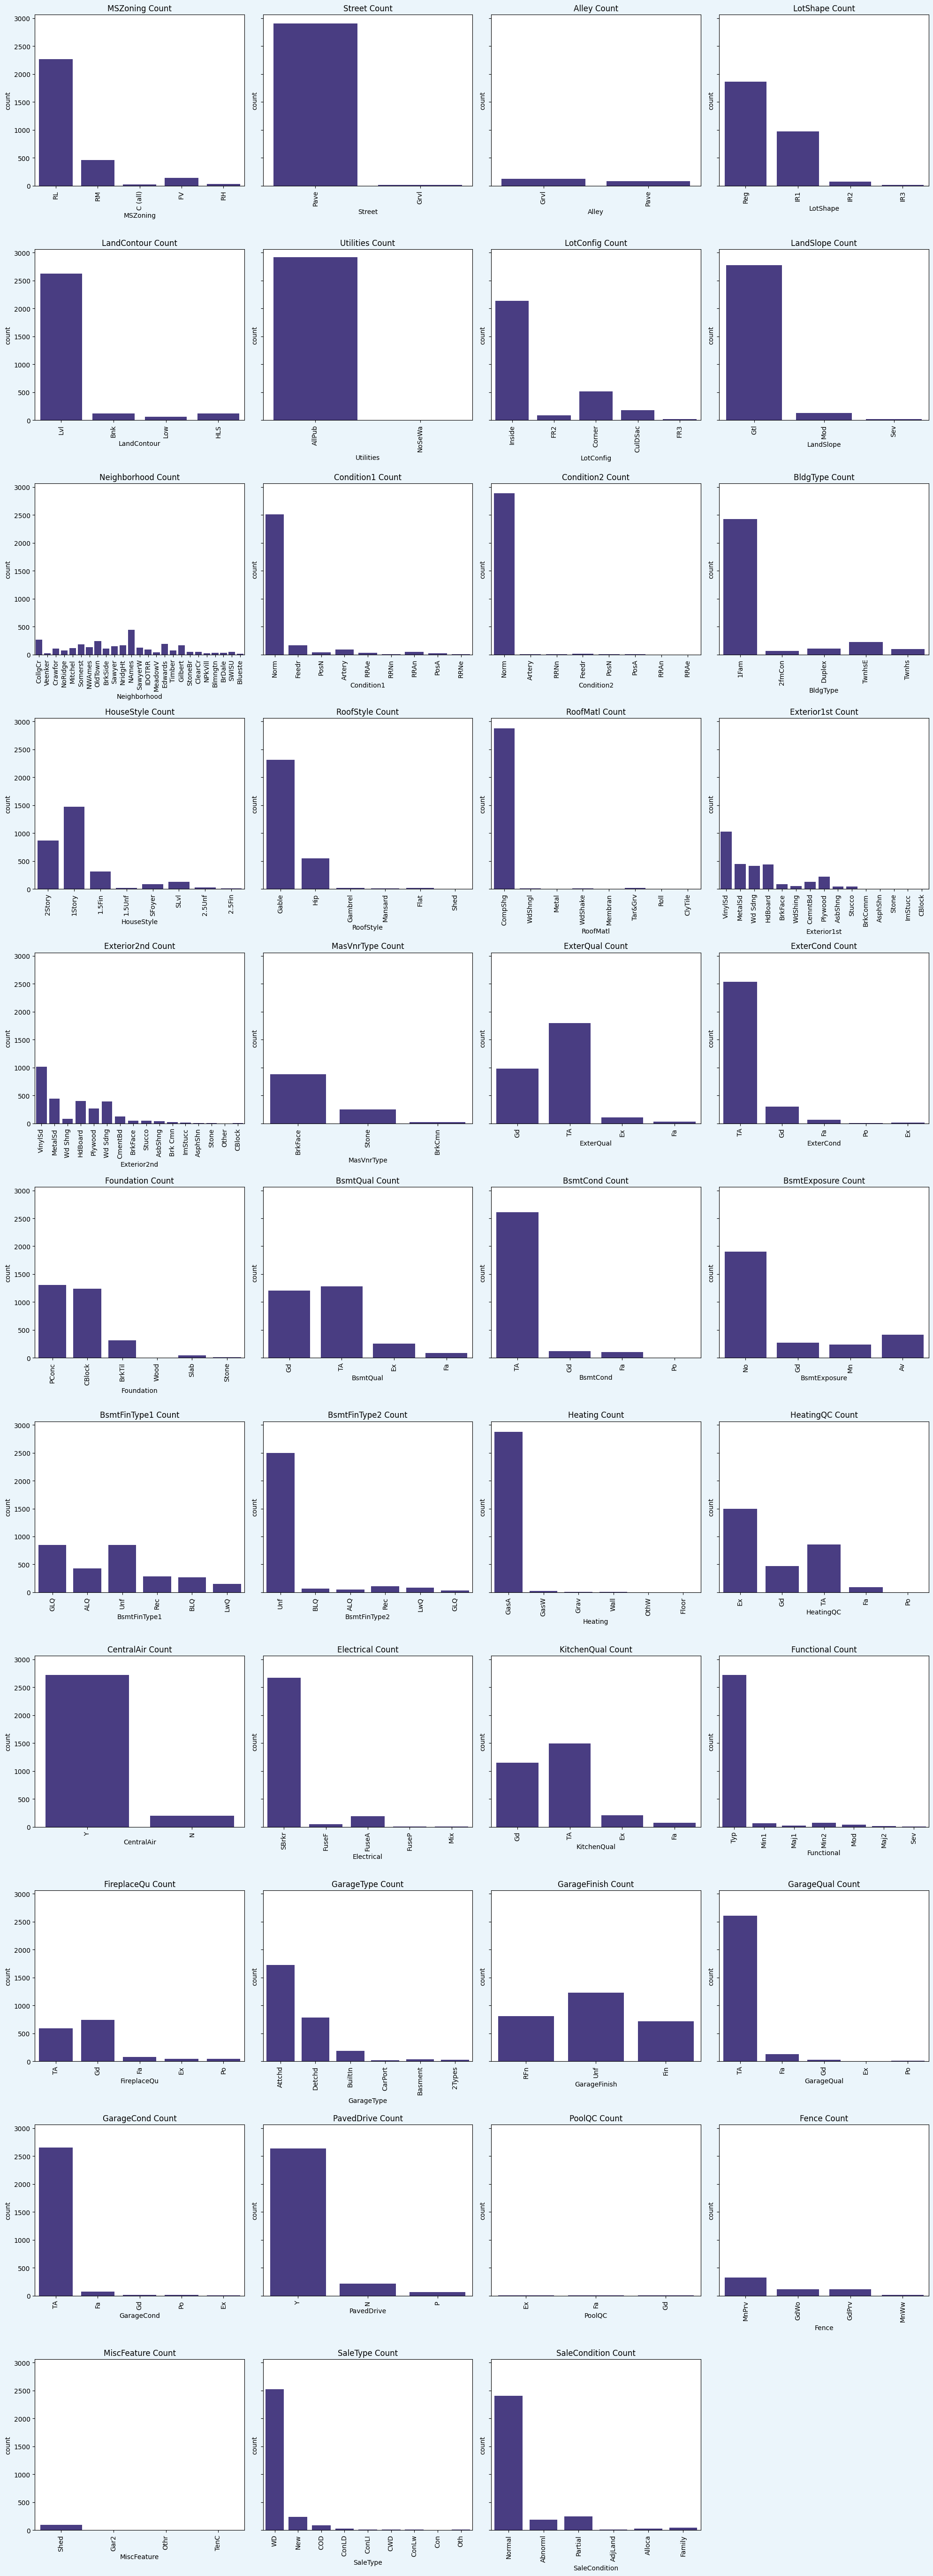

In [5]:
def cat_summary(dataframe, cat_cols):
    num_cols = len(cat_cols)
    num_rows = (num_cols + 3) // 4
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows), sharey=True)
    fig.patch.set_facecolor('#EBF5FB')

    flat_axes = axes.flatten()

    for i, col_name in enumerate(cat_cols):
        sns.countplot(x=dataframe[col_name], data=dataframe, color='#42328d', ax=flat_axes[i])
        flat_axes[i].set_title(f'{col_name} Count')
        flat_axes[i].tick_params(axis='x', rotation=90)

    for i in range(num_cols, num_rows * 4):
        fig.delaxes(flat_axes[i])

    plt.tight_layout()
    plt.show()

cat_summary(df, cat_cols)


## **4. Analysis of Numerical Variables**

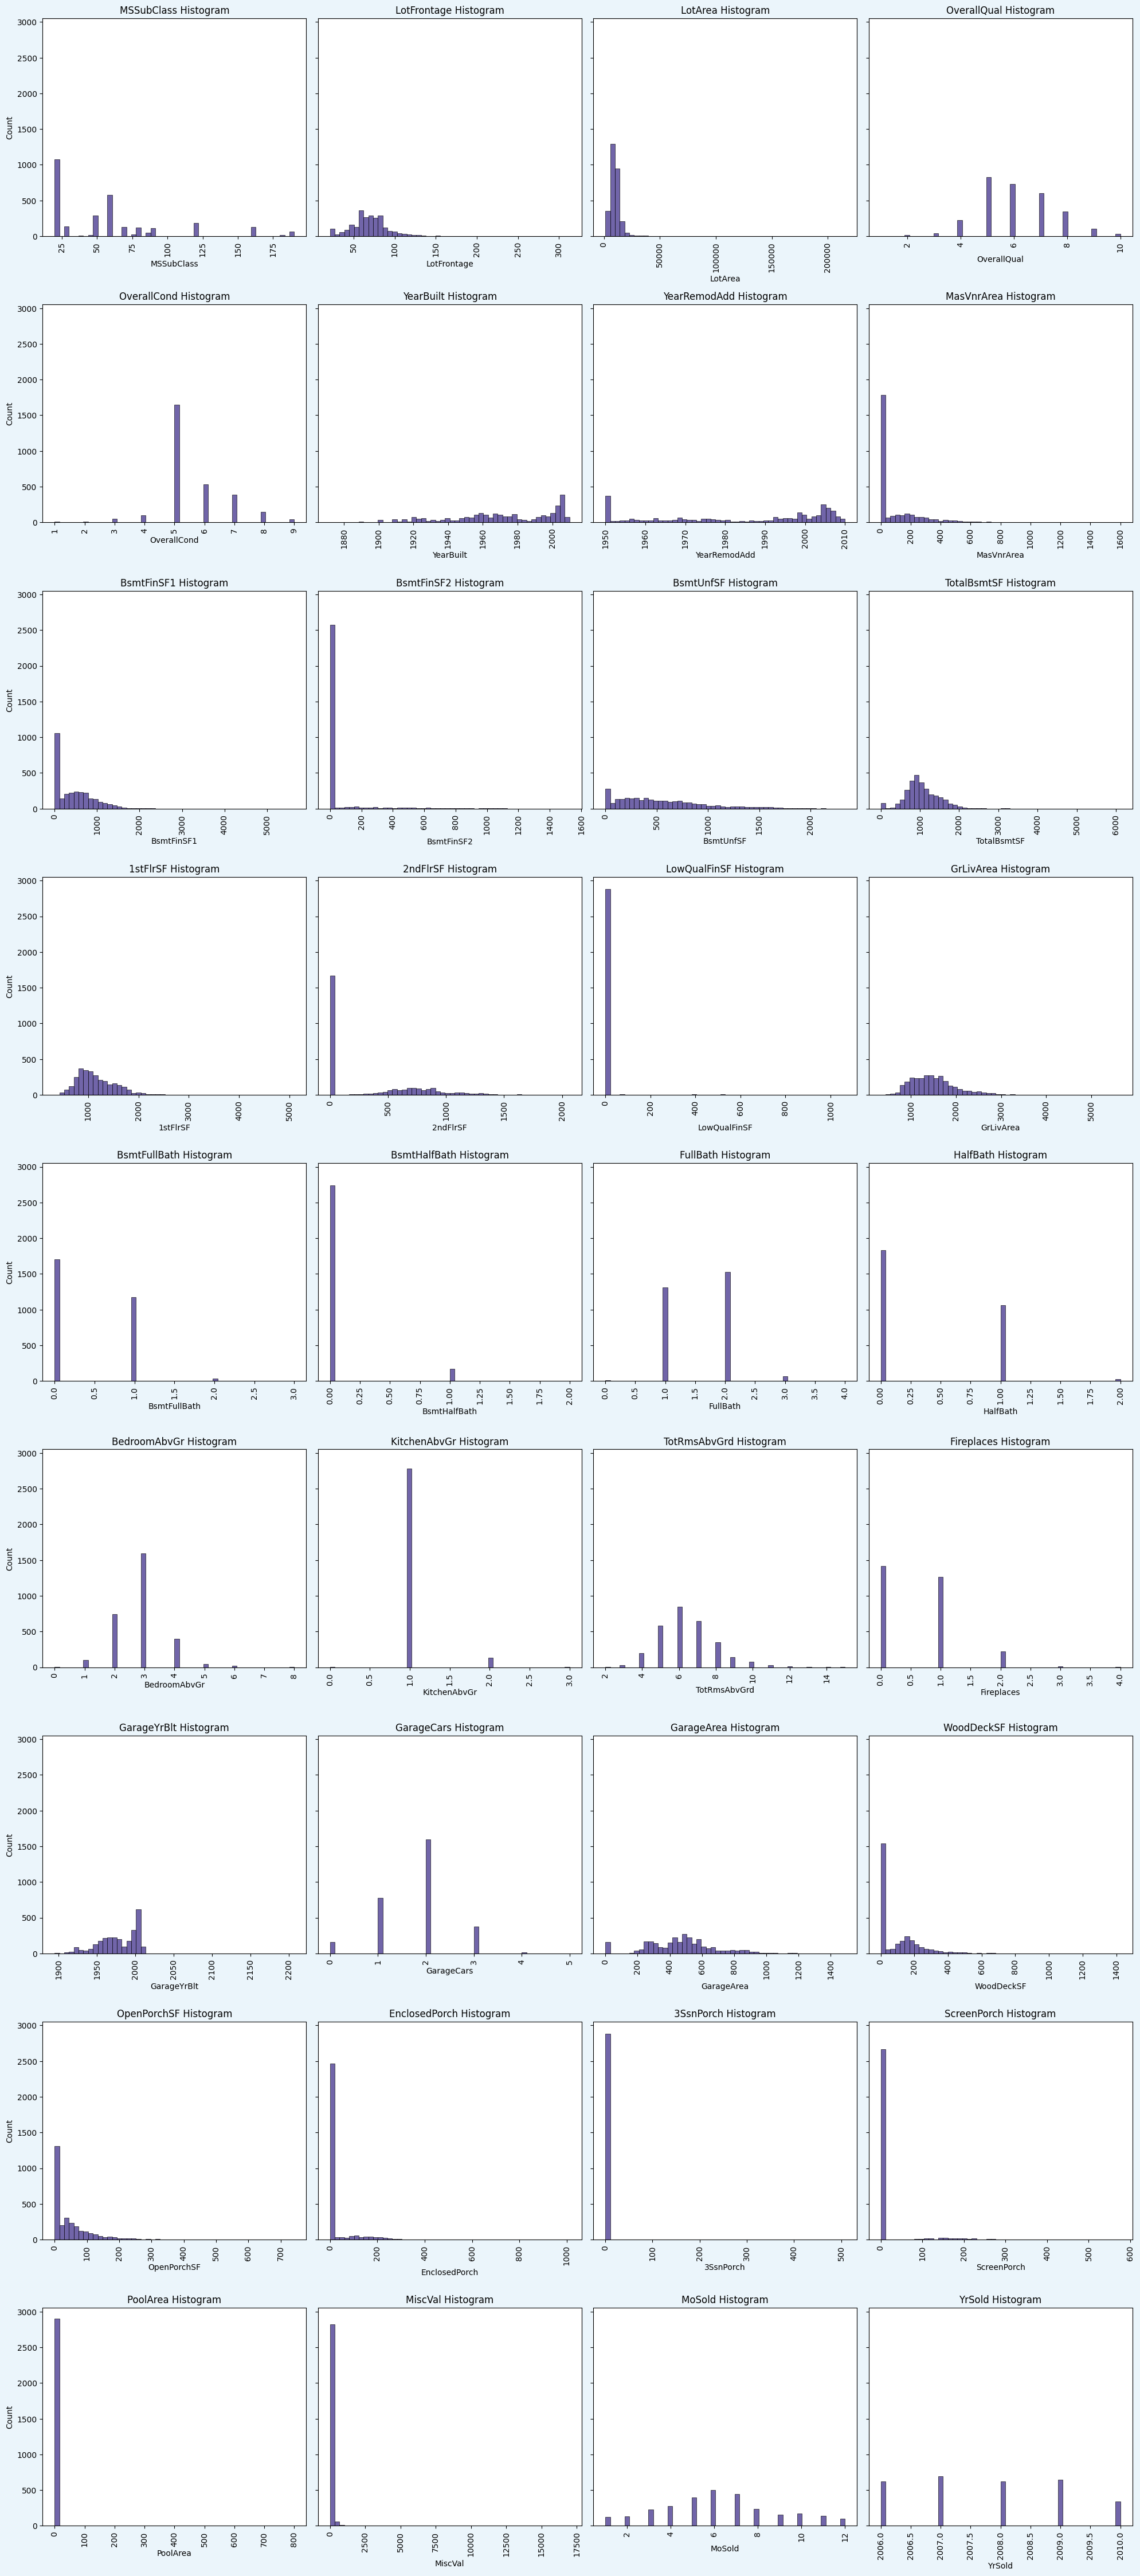

In [6]:
def num_summary_plot(dataframe, num_cols):
    
    num_rows = (len(num_cols) + 3) // 4 
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows), sharey=True)
    fig.patch.set_facecolor('#EBF5FB')

    flat_axes = axes.flatten()

    for i, numerical_col in enumerate(num_cols):
        sns.histplot(dataframe[numerical_col], bins=50, color="#42328d", kde=False, ax=flat_axes[i])
        flat_axes[i].set_xlabel(numerical_col)
        flat_axes[i].set_title(f'{numerical_col} Histogram')
        flat_axes[i].tick_params(axis='x', rotation=90) 

    for i in range(len(num_cols), num_rows * 4):
        fig.delaxes(flat_axes[i])

    plt.tight_layout()
    plt.show()

num_summary_plot(df, num_cols)


## **5. Analysis of Target Variable**

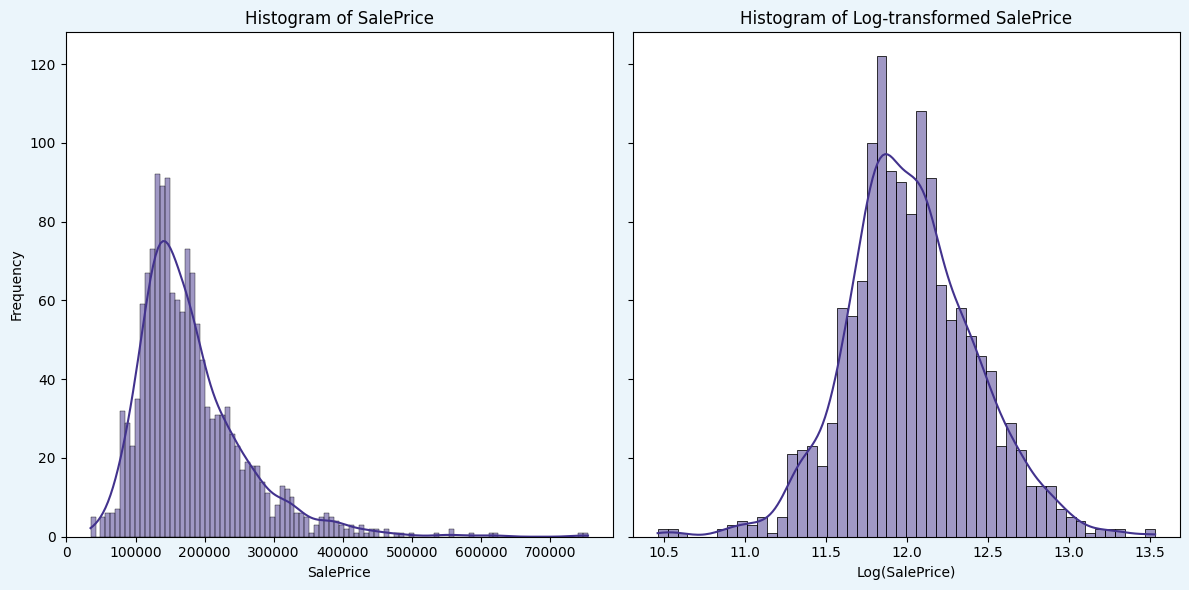

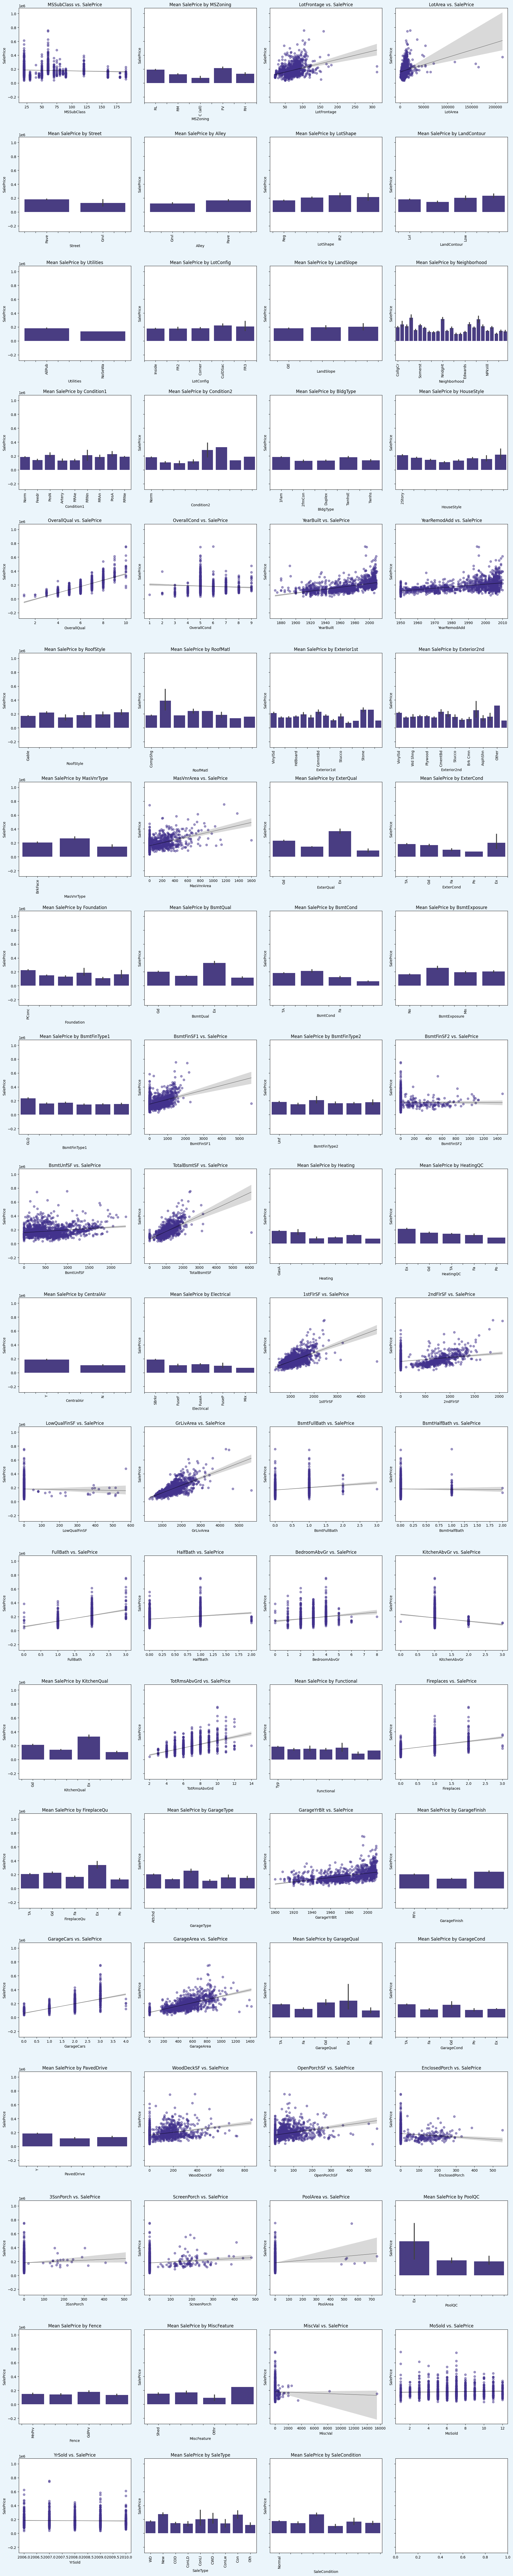

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
fig.patch.set_facecolor('#EBF5FB')

sns.histplot(train["SalePrice"], bins=100, kde=True, color='#42328d', ax=axes[0])
axes[0].set_title('Histogram of SalePrice')
axes[0].set_xlabel('SalePrice')
axes[0].set_ylabel('Frequency')

sns.histplot(np.log1p(train['SalePrice']), bins=50, kde=True, color='#42328d', ax=axes[1])
axes[1].set_title('Histogram of Log-transformed SalePrice')
axes[1].set_xlabel('Log(SalePrice)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


def target_summary_plot(dataframe, target):
    selected_columns = [col for col in dataframe.columns if col not in [target]]

    num_rows = (len(selected_columns) + 3) // 4

    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows), sharey=True)
    fig.patch.set_facecolor('#EBF5FB')

    for i, column in enumerate(selected_columns):
        row, col = divmod(i, 4)

        if dataframe[column].dtype in ['int64', 'float64']:
            sns.regplot(x=column, y=target, data=dataframe, ax=axes[row, col],
                        scatter_kws={"color": '#42328d', 'alpha': 0.5}, 
                        line_kws={"color": '#000000', "linewidth": 0.5})
            axes[row, col].set_title(f'{column} vs. {target}')
        elif dataframe[column].dtype == 'object':
            sns.barplot(x=column, y=target, data=dataframe, ax=axes[row, col], color='#42328d')
            axes[row, col].set_title(f'Mean {target} by {column}')
            axes[row, col].tick_params(axis='x', rotation=90)
            axes[row, col].get_xaxis().set_major_locator(MaxNLocator(nbins=10))
        else:
            print(f"Warning: Skipping {column} as it is neither numeric nor categorical.")

    plt.tight_layout()
    plt.show()


target = "SalePrice"
target_summary_plot(train, target)




# **B. Feature Engineering**


<p style="font-size: 18px; text-align: justify;">Feature engineering involves the process of transforming and creating new features from existing ones in a dataset to enhance the performance of machine learning models. This can include scaling, combining, or generating new variables to provide more meaningful insights or improve the predictive power of the model. In the upcoming sections, we will delve into outlier analysis to identify and handle extreme values that might impact model performance. Following that, an analysis of missing values will be conducted to address any data gaps, ensuring a comprehensive dataset. Additionally, necessary encoding processes will be applied to handle categorical variables appropriately. These steps collectively contribute to refining the dataset, optimizing its information content, and preparing it for subsequent stages of analysis and model development.</p>

## **1. Handling Outliers**

In [8]:
def handle_outliers(data, lower_quantile=0.01, upper_quantile=0.99):

    for column in data.select_dtypes(include='number').columns:
        lower_bound = data[column].quantile(lower_quantile)
        upper_bound = data[column].quantile(upper_quantile)
        iqr = upper_bound - lower_bound
        upper_limit = upper_bound + 1.5 * iqr
        lower_limit = lower_bound - 1.5 * iqr

        # Adjust outliers by capping them with their respective limits
        data.loc[(data[column] < lower_limit), column] = lower_limit
        data.loc[(data[column] > upper_limit), column] = upper_limit
    
    return data

df = handle_outliers(df)


## **2. Handling Missing Values**


In [9]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    
    dtype = dataframe.dtypes[na_columns].astype(str)

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([dtype, n_miss, np.round(ratio, 2)], axis=1, keys=['dtype','n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df)

                dtype  n_miss  ratio
MSZoning       object       4   0.14
LotFrontage   float64     486  16.65
Alley          object    2721  93.22
Utilities      object       2   0.07
Exterior1st    object       1   0.03
Exterior2nd    object       1   0.03
MasVnrType     object    1766  60.50
MasVnrArea    float64      23   0.79
BsmtQual       object      81   2.77
BsmtCond       object      82   2.81
BsmtExposure   object      82   2.81
BsmtFinType1   object      79   2.71
BsmtFinSF1    float64       1   0.03
BsmtFinType2   object      80   2.74
BsmtFinSF2    float64       1   0.03
BsmtUnfSF     float64       1   0.03
TotalBsmtSF   float64       1   0.03
Electrical     object       1   0.03
BsmtFullBath  float64       2   0.07
BsmtHalfBath  float64       2   0.07
KitchenQual    object       1   0.03
Functional     object       2   0.07
FireplaceQu    object    1420  48.65
GarageType     object     157   5.38
GarageYrBlt   float64     159   5.45
GarageFinish   object     159   5.45
G

<p style="font-size: 18px; text-align: justify;">The dataset highlights variables with missing values, ranging from 1 to 2909 instances. Prominent variables such as 'PoolQC,' 'MiscFeature,' and 'Fence' exhibit substantial missing data, exceeding 80% of the total observations. Variables like 'GarageYrBlt' and 'LotFrontage' also present notable percentages of missing values. Addressing and imputing these missing values will be crucial during the subsequent data preprocessing steps to ensure a comprehensive and accurate dataset for effective model development.</p>

In [10]:
columns_with_none = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual',
                     'GarageCond', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                     'Utilities', 'GarageArea', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                     'TotalBsmtSF','BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea',"BedroomAbvGr", "GarageYrBlt"]


def fill_missing_values(df, columns):
    for column in columns:
        if df[column].dtype == "O":
            imputer = SimpleImputer(strategy='constant', fill_value='None')
        elif pd.api.types.is_numeric_dtype(df[column]):  
            imputer = SimpleImputer(strategy='constant', fill_value=0)
        else:
            print(f"Warning: Unknown type for column '{column}'. Skipping.")
            continue

        df[column] = imputer.fit_transform(df[[column]]).ravel()

fill_missing_values(df, columns_with_none)

missing_values_table(df)

               dtype  n_miss  ratio
MSZoning      object       4   0.14
LotFrontage  float64     486  16.65
Exterior1st   object       1   0.03
Exterior2nd   object       1   0.03
Electrical    object       1   0.03
KitchenQual   object       1   0.03
Functional    object       2   0.07
SaleType      object       1   0.03
SalePrice    float64    1459  49.98


<p style="font-size: 18px; text-align: justify;"> Upon scrutinizing the missing values, it was evident that specific features, including 'PoolQC,' 'MiscFeature,' 'Alley,' 'Fence,' 'FireplaceQu,' 'GarageType,' 'GarageFinish,' 'GarageQual,' 'GarageCond,' 'MasVnrType,' 'BsmtQual,' 'BsmtCond,' 'BsmtExposure,' 'BsmtFinType1,' 'BsmtFinType2,' 'Utilities,' 'GarageArea,' 'GarageArea,' 'GarageCars,' 'BsmtFinSF1,' 'BsmtFinSF2,' 'BsmtUnfSF,' 'TotalBsmtSF,' 'BsmtFullBath,' 'BsmtHalfBath,' 'MasVnrArea,' 'BedroomAbvGr,' and 'GarageYrBlt,' did not exhibit any missing values. This absence of missing values implies that these specific features are not present in the corresponding houses. Consequently, to fill in these gaps systematically, categorical features were imputed with 'None,' while numeric features were replaced with 0. This meticulous approach ensures the dataset's completeness and prepares it for subsequent analytical processes, contributing to a more accurate and reliable dataset for comprehensive model development. </p>

In [11]:
base_list = ['LotShape', 'LotArea','LotConfig']
df_lot = df[base_list].copy()
    
categoric_columns = [col for col in base_list if df[col].dtype == "O"]

df_lot = pd.get_dummies(df[['LotFrontage', 'LotShape', 'LotArea','LotConfig']].copy(), columns=categoric_columns)

imputer = IterativeImputer(max_iter=10, random_state=42)

df['LotFrontage'][df['LotFrontage'].isnull()] = imputer.fit_transform(df_lot)


/tmp/ipykernel_19/1762751887.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LotFrontage'][df['LotFrontage'].isnull()] = imputer.fit_transform(df_lot)


<p style="font-size: 18px; text-align: justify;"> For the 'LotFrontage' feature, which is influenced by 'LotShape,' 'LotArea,' and 'LotConfig,' I utilized the iterative imputer technique to fill in missing values. This method considers the interdependencies between variables, resulting in a more accurate estimation of missing values. This approach enhances the dataset's completeness and ensures that imputed values align closely with the underlying patterns in the data. </p>

In [12]:
imputer = SimpleImputer(strategy='most_frequent')

null_columns = df.columns[df.isnull().any() & (df.columns != 'SalePrice')].tolist()

df[null_columns] = imputer.fit_transform(df[null_columns])

missing_values_table(df)

             dtype  n_miss  ratio
SalePrice  float64    1459  49.98


<p style="font-size: 18px; text-align: justify;"> The remaining missing values were filled using the SimpleImputer, where the most frequent values within each respective column were employed for imputation. The utilization of SimpleImputer contributes to the overall data imputation strategy, creating a more complete and reliable dataset for subsequent analyses and modeling endeavors. Thus, there are no missing values in the dataset except for the target variable. </p>

## **3. Rare Analysis**

<p style="font-size: 18px; text-align: justify;"> Rare Analysis refers to the examination of categorical variables to identify and assess infrequent or rare categories. This analysis helps in understanding the impact of rare categories on the model training process. By recognizing and handling rare observations appropriately, we aim to ensure that our model effectively learns from and adapts to less common categories, especially in scenarios where class imbalance may affect the model's performance, such as in classification problems. </p>

In [13]:
def rare_encoder(df, threshold=0.05, replace_with='Rare'):

    for col in df.select_dtypes(include='object').columns:

        value_counts = df[col].value_counts(normalize=True)
        rare_categories = value_counts[value_counts < threshold].index
        df[col] = df[col].apply(lambda x: replace_with if x in rare_categories else x)
    
    return df

df = rare_encoder(df, threshold=0.10)

## **4. Encoding and Feature Engineering**


In [14]:
feature_orders = {
    'Street': ["Grvl", "Pave"],
    'Alley': ["None", "Grvl", "Pave"],
    'LotShape': ["IR3",'IR2','IR1','Reg'],
    'LandContour': ['Low','HLS', 'Bnk', 'Lvl'],
    'Utilities':['ELO','NoSeWa','NoSewr','AllPub'],
    'LandSlope': ['Sev','Mod','Gtl'],
    'ExterQual': ['Po','Fa','TA','Gd','Ex'],
    'ExterCond': ['Po','Fa','TA','Gd','Ex'],
    'BsmtQual': ['None','Po','Fa','TA','Gd','Ex'],
    'BsmtCond': ['None','Po','Fa','TA','Gd','Ex'],
    'BsmtExposure':['None', 'No','Mn','Av','Gd'],
    'BsmtFinType1': [ 'None','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
    'BsmtFinType2': [ 'None','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
    'HeatingQC': ['Po','Fa','TA','Gd','Ex'],
    'CentralAir': ['N','Y'],
    'KitchenQual': ['Po','Fa','TA','Gd','Ex'],
    'Functional':['Sal','Sev','Maj2','Maj1','Mod','Min2', 'Min1','Typ'],
    'FireplaceQu':['None','Po','Fa','TA','Gd','Ex'],
    'GarageFinish': ['None','Unf','RFn','Fin'],
    'GarageQual': ['None','Po','Fa','TA','Gd','Ex'],
    'GarageCond': ['None','Po','Fa','TA','Gd','Ex'],
    'PavedDrive':[ 'N', 'P','Y'],
    'PoolQC': ['None','Fa','TA','Gd','Ex'],
    'Fence':['None','MnWw','GdWo','MnPrv', 'GdPrv']
}

def ordinal_encoder(df):
    encoded_features = {}
    for feature_name, order in feature_orders.items():
        encoder = OrdinalEncoder(categories=[order], handle_unknown='use_encoded_value', unknown_value=-1)
        df[feature_name] = encoder.fit_transform(df[[feature_name]])
    return df

df = ordinal_encoder(df)

df = handle_outliers(df)

<p style="font-size: 18px; text-align: justify;"> I identified features with inherent ordinality and proceeded to implement the ordinal encoder. This encoding technique preserves the ordinal relationship between different categories within a feature, ensuring a meaningful representation for the model. The ordinal encoder is applied to enhance the dataset's structure, allowing for more effective utilization of ordinal information in subsequent analyses and model development stages. </p>

In [15]:
df['TotalRms'] = df['TotRmsAbvGrd'] + df['FullBath']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df["AllSF"] = df["GrLivArea"] + df["TotalBsmtSF"] + df['1stFlrSF'] + df['2ndFlrSF']
df["OverallGrade"] = df["OverallQual"] * df["OverallCond"]
df["TotalBath"] = df["BsmtFullBath"] + (0.5 * df["BsmtHalfBath"]) + df["FullBath"] + (0.5 * df["HalfBath"])  
df["GarageGrade"] = df["GarageQual"] * df["GarageCond"]
df['LandScore'] = df['LandContour'] * df['LandSlope']
df["BsmtScore"] = df["BsmtExposure"] * df["BsmtCond"]
df['TotBsmtFinScore'] = (df['BsmtFinSF1']*df['BsmtFinType1'] + df['BsmtFinSF2']*df['BsmtFinType2']) 
df['PoolPrivacy'] = df['PoolArea'] * df['Fence']
df["TotPorchSF"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"]
df["GarageScore"] = df["GarageArea"] * df["GarageQual"]
df["ExterGrade"] = df["ExterQual"] * df["ExterCond"]
df["KitchenScore"] = df["KitchenAbvGr"] * df["KitchenQual"]
df["FireplaceScore"] = df["Fireplaces"] * df["FireplaceQu"]
df["PoolScore"] = df["PoolArea"] * df["PoolQC"]

<p style="font-size: 18px; text-align: justify;"> I crafted new features to enhance their relevance for modeling, aiming to boost predictive performance and uncover deeper insights within the dataset. </p>

In [16]:

df = df.drop(columns=["GarageArea", "TotRmsAbvGrd", "OverallQual", "OverallCond",
                      "KitchenAbvGr", "KitchenQual", "BsmtFullBath", "BsmtHalfBath",
                      "HalfBath"], axis=1)


<p style="font-size: 18px; text-align: justify;"> I dropped irrelevant features to streamline the dataset for more effective modeling, aiming for improved interpretability and performance. </p>

In [17]:
scaler = MinMaxScaler()

numeric_columns = df.select_dtypes(include='number').columns

numeric_columns = numeric_columns.drop('SalePrice')

df[numeric_columns] = scaler.fit_transform(df[numeric_columns])


<p style="font-size: 18px; text-align: justify;"> I utilized the MinMaxScaler from scikit-learn to normalize the numeric features in the dataset. The scaler is applied specifically to columns containing numerical data (excluding the 'SalePrice' column). The MinMaxScaler scales each feature to a specified range (typically between 0 and 1), ensuring that all numeric variables contribute uniformly to the model without being disproportionately influenced by their original scales. This normalization step is crucial for certain machine learning algorithms that are sensitive to the magnitude of input features, promoting stability and convergence during model training. </p>

In [18]:
def one_hot_encode(df, cols):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    ohe_df = pd.DataFrame(ohe.fit_transform(df[cols]), columns=ohe.get_feature_names_out(cols))
    ohe_df.index = df.index  
    df = pd.concat([df, ohe_df], axis=1)
    df.drop(cols, axis=1, inplace=True)
    return df

df = one_hot_encode(df, df.select_dtypes('object').columns)

missing_values_table(df)

             dtype  n_miss  ratio
SalePrice  float64    1459  49.98


<p style="font-size: 18px; text-align: justify;"> In the provided process, one-hot encoding is applied to categorical columns in the dataset. This transformation converts categorical variables into binary vectors, creating new binary columns for each category. The purpose is to prepare the data for machine learning models that require numerical input. The function used ensures efficient handling of unknown categories during encoding. After one-hot encoding, any remaining missing values in the dataset are checked and displayed, ensuring the dataset is thoroughly preprocessed and ready for subsequent analysis or model development. </p>


# **C. Modeling**

In [19]:
train = df.dropna(subset=['SalePrice'])
test = df[df['SalePrice'].isna()]

y = np.log1p(train['SalePrice'])
X = train.drop(["SalePrice"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


<p style="font-size: 18px; text-align: justify;"> The dataset is divided into training and test sets based on the presence of 'SalePrice' values. The target variable 'SalePrice' undergoes a log transformation for the training set ('y'). Independent variables are extracted into 'X.' The dataset is split into training and testing subsets, allocating 25% to the test set. This prepares the data for subsequent model training and evaluation. </p>

In [20]:
algorithms = [
    ("GradientBoosting", GradientBoostingRegressor(random_state=42)),
    ("ExtraTrees", ExtraTreesRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42)),
    ("LGBM", LGBMRegressor(random_state=42)),
    ("HistGradientBoosting", HistGradientBoostingRegressor(random_state=42)),
    ("CatBoost", CatBoostRegressor(random_state=42, verbose=0)),
    ("ElasticNet", ElasticNet(random_state=42)),
    ("Lasso", Lasso(random_state=42))
]

for name, regressor in algorithms:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")


RMSE: 0.128 (GradientBoosting) 
RMSE: 0.1379 (ExtraTrees) 
RMSE: 0.1429 (XGBoost) 
RMSE: 0.1332 (LGBM) 
RMSE: 0.1329 (HistGradientBoosting) 
RMSE: 0.1236 (CatBoost) 
RMSE: 0.3992 (ElasticNet) 
RMSE: 0.3992 (Lasso) 


<p style="font-size: 18px; text-align: justify;"> The root mean square error (RMSE) values were computed for various regression models applied to the dataset. Among the ensemble methods, CatBoost exhibited the lowest RMSE of 0.1236, showcasing its superior predictive performance. GradientBoosting, ExtraTrees, XGBoost, LGBM, and HistGradientBoosting also demonstrated competitive RMSE values ranging from 0.128 to 0.1429. However, ElasticNet and Lasso, both linear regression models, displayed higher RMSE values of 0.3992, indicating a comparatively weaker fit to the data. These results provide insights into the relative efficacy of different models in predicting the target variable, highlighting the strengths of ensemble methods like CatBoost in this context. </p>

In [21]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

study_catboost = optuna.create_study(direction='minimize')

study_catboost.optimize(
    lambda trial: mean_squared_error(
        y_test,
        CatBoostRegressor(
            objective='RMSE',
            depth=trial.suggest_int('depth', 4, 10),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
            iterations=trial.suggest_int('iterations', 500, 1500),
            random_strength=trial.suggest_float('random_strength', 0.1, 1.0),
            bagging_temperature=trial.suggest_float('bagging_temperature', 0.0, 10.0),
            border_count=trial.suggest_int('border_count', 5, 255),
            l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 1e-5, 100),
            random_state=trial.suggest_categorical('random_state', [42]),
            verbose=False
        ).fit(X_train, y_train).predict(X_test),
        squared=False
    ),
    n_trials=50
)

best_params_catboost = study_catboost.best_params

final_model_catboost = CatBoostRegressor(**best_params_catboost, verbose=False)
final_model_catboost.fit(X_train, y_train)
y_pred = final_model_catboost.predict(X_test)

print('Error: ', mean_squared_error(y_test,y_pred, squared=False))


Error:  0.1254720360546451


<p style="font-size: 18px; text-align: justify;"> I conducted hyperparameter optimization using Optuna for a CatBoostRegressor model to minimize the root mean squared error (RMSE). The study involved exploring various hyperparameters, such as depth, learning rate, iterations, random strength, bagging temperature, border count, and L2 leaf regularization. The optimization process aimed to find the combination of hyperparameter values that yielded the lowest RMSE on the test set. After 50 trials, the best hyperparameters were identified, and a final CatBoost model was trained using these optimized parameters. The model's performance was evaluated on the test set, and the resulting RMSE was computed to assess the predictive accuracy of the optimized CatBoostRegressor.  </p>

In [22]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

study_lgbm = optuna.create_study(direction='minimize')

study_lgbm.optimize(
    lambda trial: mean_squared_error(
        y_test,
        LGBMRegressor(
            objective='root_mean_squared_error',
            max_depth=trial.suggest_int('max_depth', 3, 10),
            num_leaves=trial.suggest_int('num_leaves', 8, 1024),
            min_child_samples=trial.suggest_int('min_child_samples', 5, 30),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.10, log=True),
            n_estimators=trial.suggest_int('n_estimators', 700, 1600),
            min_child_weight=trial.suggest_int('min_child_weight', 10, 25),
            subsample=trial.suggest_float('subsample', 0.5, 1.0),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.01, 0.5),
            reg_alpha=trial.suggest_float('reg_alpha', 0.01, 0.5),
            reg_lambda=trial.suggest_float('reg_lambda', 0.5, 1.0),
            random_state=trial.suggest_categorical('random_state', [42]),
        ).fit(X_train, y_train).predict(X_test),
        squared=False
    ),
    n_trials=100
)

best_params_lgbm = study_lgbm.best_params

final_model_lgbm = LGBMRegressor(**best_params_lgbm, verbose=-1)
final_model_lgbm.fit(X_train, y_train)
y_pred = final_model_lgbm.predict(X_test)

print('Error: ', mean_squared_error(y_test,y_pred, squared=False))


Error:  0.1279498381324565


<p style="font-size: 18px; text-align: justify;"> I also applied hyperparameter optimization using Optuna for a GradientBoostingRegressor model.  </p>

In [23]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

study_gradient_boosting = optuna.create_study(direction='minimize')

def objective_gradient_boosting(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': trial.suggest_categorical('random_state', [42]),
    }

    model_gb = GradientBoostingRegressor(**params)
    model_gb.fit(X_train, y_train)
    y_pred_gb = model_gb.predict(X_test)
    
    return mean_squared_error(y_test, y_pred_gb, squared=False)

study_gradient_boosting.optimize(objective_gradient_boosting, n_trials=50)

best_params_gb = study_gradient_boosting.best_params

final_model_gb = GradientBoostingRegressor(**best_params_gb)
final_model_gb.fit(X_train, y_train)
y_pred_gb_final = final_model_gb.predict(X_test)

error_gb_final = mean_squared_error(y_test, y_pred_gb_final, squared=False)
print('GradientBoostingRegressor Error: ', error_gb_final)


GradientBoostingRegressor Error:  0.1296106890978276


<p style="font-size: 18px; text-align: justify;"> Finally, I also utilized Optuna for hyperparameter optimization of a GradientBoostingRegressor model. </p>

In [24]:
base_models = [
    ('final_model_catboost', final_model_catboost),
    ('final_model_lgbm', final_model_lgbm),
    ('final_model_gb', final_model_gb)
]

final_estimator = final_model_catboost

stacking_model = StackingRegressor(estimators=base_models, final_estimator=final_estimator)

stacking_model.fit(X_train, y_train)

y_pred_stacked = stacking_model.predict(X_test)


<p style="font-size: 18px; text-align: justify;"> I implemented a stacking ensemble model, utilizing three base models: 'final_model_catboost,' 'final_model_lgbm,' and 'final_model_gb.' The stacking model is trained with these base models, and predictions are made on the test set ('X_test'). The stacking process combines the predictions of individual models to enhance overall predictive accuracy, with 'final_model_catboost' serving as the final estimator. The resulting predictions, denoted as 'y_pred_stacked,' represent the ensemble model's aggregated output on the test set. This stacking approach aims to leverage the diverse strengths of the individual base models to achieve improved performance in predicting the target variable. </p> 

# **D. Submission**


In [25]:
submission= pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

submission['SalePrice'] = np.exp(stacking_model.predict(test.drop(["SalePrice"], axis=1)))

submission.to_csv('submission.csv', index=False)